In [1]:
print(__doc__)
from time import time
import datetime

import numpy as np
from scipy import ndimage
from time import time
import pandas as pd
from skimage import measure
from skimage import io
import ImageAnalysis
import Morphology

from pathlib import Path
import pathlib
import os
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize_3d
import sknw
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
import os
import seaborn as sns

Automatically created module for IPython interactive environment


In [2]:
imagePath = "/Volumes/Extreme SSD/RESEARCH/2023/Sholto Metformin/"
csvPath = "/Volumes/Extreme SSD/RESEARCH/2023/Sholto Metformin CSV/"
# csvPath = "/Volumes/Extreme SSD/RESEARCH/2023/Sholto Metformin CSV Trimmed/"
output_path = "/Volumes/Extreme SSD/RESEARCH/2023/Sholto Metformin Output/"

delete_fields = ["area", "form_factor_3D_relative", "volume_3D_relative", "convex_area_3D_relative",
                 "convex_area", "AspectRatio3D Middle/Minor", "num_connected_components", "total_num_nodes", 
                 "solidity"]

size_xy_um = 0.1661
size_z_um = 0.2
scaleFactor = 3.0

loadImages = False
recalculate = False


In [3]:
# read the groups as the subfolders of the path (each group is a subfolder) only retain the subfolder name
groups = [f for f in os.listdir(imagePath) if not f.startswith('.')]

print(groups)
labels = ['B', 'C', 'CB', 'MCB', 'M']

# retain control and other group
# other = 4 # index of the group to be combined with control
# groups = [groups[1], groups[other]] 
# labels = [labels[1], labels[other]]

# Manually select two groups to compare
first = 0
other = 1
groups = [groups[first], groups[other]] 
labels = [labels[first], labels[other]]


print("Processing groups: ", groups)

['Baf', 'Control', 'CCCP+Baf', 'Met+CCCP+Baf', 'Metformin']
Processing groups:  ['Baf', 'Control', 'CCCP+Baf', 'Met+CCCP+Baf', 'Metformin']


### Load images

In [4]:
# # create a list of all the files in the directory (ending in .tif) storing them in a dictionary using the names of groups as the keys
# files = {}
# for group in groups:
#     files[group] = [f for f in os.listdir(imagePath + group) if f.endswith('.tif') and not (f.startswith('.') or f.startswith('_'))]

# print(files)

# # print the number of files per group
# for group in groups:
#     print(group + ': ' + str(len(files[group])))

In [5]:
# # read all the images in each folder and save them in a dictionary
# # the key is the folder name, the value is a list of images
# images = {}

# if loadImages:
#     for group in groups:
#         images[group]= []
#         for fName in files[group]:
#         #    print("Loading image: " + fName)
#             images[group].append(io.imread(imagePath + group + "/" + fName)) 

In [6]:
# images[groups[1]][0].shape

### Calculate Properties (and/or load from CSV)

In [7]:
# propertiesCalculated = {}

# if recalculate:
#     for group in groups:
#         propertiesCalculated[group]= []
#         for index, image in enumerate(images[group]):
#             try:
#                 propertiesCalculated[group].append(Morphology.calculateAllParameters_scales(image, image, size_xy_um, size_z_um, scaleFactor))
#             except:
#                 print('Error with image: ' + files[group][index])
#                 continue

In [8]:
propertiesFromFiles = {}
for group in groups:
    print(group)
    df = pd.read_csv(csvPath + group + '.csv')
    # use the values in the 'Fusion' and 'Fission' columns to calculate the 'Fission/Fusion' column and add it to the dataframe
    df['Fission/Fusion'] = df['Fission'] / df['Fusion']
    df['Group'] = group
    propertiesFromFiles[group] = df

Baf
Control
CCCP+Baf
Met+CCCP+Baf
Metformin


In [9]:
# propertiesFromFiles[groups[0]]

In [10]:
# normalize data
from sklearn import preprocessing


combinedDataFrame = pd.DataFrame()
for group in groups:
    df = propertiesFromFiles[group]
    if(combinedDataFrame.columns.size == 0):
        combinedDataFrame = df
    else:
        combinedDataFrame = combinedDataFrame.append(df, sort=False)
    
print(combinedDataFrame.columns)
# Select the columns that we want to use for the manifold (from Fusion until Fission/Fusion)
dfSelected = combinedDataFrame.loc[:, 'Fusion':'Fission/Fusion']
# remove delete_fields from dfSelected
dfSelected = dfSelected.drop(delete_fields, axis=1)

# NOTE: This is due to a bug in the code that calculates the convexity_3D_relative, and it has since been fixed, but this is a quick fix for the data that has already been calculated
print(np.max(dfSelected['convexity_3D_relative']))
# Fix the convexity_3D_relative and convex_volume_3D_relative column values. The true value should be 1/x, but the calculated value is x.
dfSelected['convexity_3D_relative'] = 1 / dfSelected['convexity_3D_relative']
print(np.max(dfSelected['convexity_3D_relative']))


print(dfSelected.columns)

dfSelected = dfSelected.rename(columns={
    'Fusion': 'Fusion Events',
    'Fission': 'Fission Events',
    'Depol': 'Depolarization Events',
    'count': 'Structure Count',
    'num_isolates': 'Number of Isolates',
    'num_selfloops': 'Number of Self-loops',
    'average_edge_length': 'Average Edge Length',
    'total_num_edges': 'Total Number of Edges',
    'extent': 'Extent',
    'filled_area': 'Filled Area',
    'aspect_ratio_major_minor': 'Aspect Ratio Major/Minor',
    'AspectRatio3D Main/Middle': 'Aspect Ratio 3D Main/Middle',
    'AspectRatio3D Main/Minor': 'Aspect Ratio 3D Main/Minor',
    'surface_area_3D_relative': 'Relative 3D Surface Area',
    'volume_3D_um': '3D Volume (µm^3)',
    'convex_volume_3D_relative': 'Relative 3D Convex Volume',
    'convexity_3D_relative': 'Relative 3D Convexity',
    'solidy_3D_relative': 'Relative 3D Solidity',
    'sphericity': 'Sphericity',
    'Fission/Fusion': 'Fission/Fusion Ratio'
})



# Create several different ways to preprocess the data using sklearn's preprocessing and comment all or them out except 1, so that you can see the effect of each one
# X_scaled = pd.DataFrame(preprocessing.scale(dfSelected),columns = dfSelected.columns)
# X_scaled = pd.DataFrame(preprocessing.normalize(dfSelected),columns = dfSelected.columns)
# X_scaled = pd.DataFrame(preprocessing.minmax_scale(dfSelected),columns = dfSelected.columns)
X_scaled = pd.DataFrame(preprocessing.robust_scale(dfSelected),columns = dfSelected.columns)
# X_scaled = pd.DataFrame(preprocessing.maxabs_scale(dfSelected),columns = dfSelected.columns)
# X_scaled = pd.DataFrame(preprocessing.quantile_transform(dfSelected),columns = dfSelected.columns)
# X_scaled = dfSelected


X = np.copy(X_scaled)
y = np.copy(combinedDataFrame.loc[:,'Group'])


Index(['Cell', 'FileName', 'Fusion', 'Fission', 'Depol', 'count',
       'num_connected_components', 'num_isolates', 'num_selfloops',
       'average_edge_length', 'total_num_nodes', 'total_num_edges', 'area',
       'extent', 'filled_area', 'aspect_ratio_major_minor', 'convex_area',
       'solidity', 'AspectRatio3D Main/Middle', 'AspectRatio3D Main/Minor',
       'AspectRatio3D Middle/Minor', 'surface_area_3D_relative',
       'volume_3D_relative', 'volume_3D_um', 'convex_area_3D_relative',
       'convex_volume_3D_relative', 'convexity_3D_relative',
       'solidy_3D_relative', 'form_factor_3D_relative', 'sphericity',
       'Fission/Fusion', 'Group'],
      dtype='object')
509.9851506
0.018215275854786047
Index(['Fusion', 'Fission', 'Depol', 'count', 'num_isolates', 'num_selfloops',
       'average_edge_length', 'total_num_edges', 'extent', 'filled_area',
       'aspect_ratio_major_minor', 'AspectRatio3D Main/Middle',
       'AspectRatio3D Main/Minor', 'surface_area_3D_relative', '

/var/folders/1g/mjb1vr296j9cpmf5wshncgm40000gn/T/ipykernel_17711/1303275773.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combinedDataFrame = combinedDataFrame.append(df, sort=False)
/var/folders/1g/mjb1vr296j9cpmf5wshncgm40000gn/T/ipykernel_17711/1303275773.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combinedDataFrame = combinedDataFrame.append(df, sort=False)
/var/folders/1g/mjb1vr296j9cpmf5wshncgm40000gn/T/ipykernel_17711/1303275773.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combinedDataFrame = combinedDataFrame.append(df, sort=False)


In [11]:
# Implement LDA using sklearn library to reduce the dimensionality of the dataset in df
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)


In [12]:
from matplotlib import offsetbox

# normalize data
from sklearn import preprocessing
# data_scaled = pd.DataFrame(preprocessing.scale(dfSelected),columns = dfSelected.columns) 
# X = np.copy(data_scaled)

n_samples, n_features = X.shape
n_neighbors = 10
save = False


#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None, numAxes=2):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    labelsUnique = np.unique(y)
    # TODO: This should not be hardcoded for generalisation
    # labelColor = {labelsUnique[0]:0, labelsUnique[1]:0.2, labelsUnique[2]:0.4, labelsUnique[3]:0.6, labelsUnique[4]:0.8}
    # labelNames = {"Baf": labels[0], "CCCP+Baf": labels[1], "Control": labels[2], "Met+CCCP+Baf": labels[3], "Metformin":labels[4]}
    labelColor = {}
    labelNames = {}
    for index, l in enumerate(labelsUnique):
        labelColor[l] = (1/len(labelsUnique)) * index
    for index, g in enumerate(groups):
        labelNames[g] = labels[index]

    if numAxes == 3: # create a 3D plot
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        for i in range(X.shape[0]):
            ax.text(X[i, 0], X[i, 1], X[i, 2], labelNames[y[i]],
                    color=plt.cm.Set2(labelColor[y[i]]),
                    fontdict={'weight': 'bold', 'size': 9})
        ax.set_xlim3d(0, 1)
        ax.set_ylim3d(0, 1)
        ax.set_zlim3d(0, 1)
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')

    elif numAxes == 2:
        plt.figure()
        ax = plt.subplot(111)
        for i in range(X.shape[0]):
            plt.text(X[i, 0], X[i, 1], labelNames[y[i]],
                    color=plt.cm.Set2(labelColor[y[i]]),
                    fontdict={'weight': 'bold', 'size': 9})

        if hasattr(offsetbox, 'AnnotationBbox'):
            # only print thumbnails with matplotlib > 1.0
            shown_images = np.array([[1., 1.]])  # just something big
            for i in range(X.shape[0]):
                dist = np.sum((X[i] - shown_images) ** 2, 1)
                if np.min(dist) < 4e-3:
                    # don't show points that are too close
                    continue
                '''
                shown_images = np.r_[shown_images, [X[i]]]
                imagebox = offsetbox.AnnotationBbox(
                    offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                    X[i])
                ax.add_artist(imagebox)
                '''
        plt.xticks([]), plt.yticks([])
    elif numAxes == 1:
        plt.figure()
        ax = plt.subplot(111)
        for i in range(X.shape[0]):
            plt.text(X[i], 0, labelNames[y[i]],
                    color=plt.cm.Set2(labelColor[y[i]]),
                    fontdict={'weight': 'bold', 'size': 9})
    if title is not None:
        plt.title(title)

    if save:
        plt.savefig(output_path + title + ".png")

Computing PCA projection
(300, 20)
(300, 2)
[[ 3.78854925e-08  2.34736383e-08 -1.46086703e-08  5.73437942e-08
   8.98091967e-08  4.03422079e-09 -4.27812367e-08  3.17392767e-08
   3.78434733e-08 -3.08892163e-08  1.00000000e+00  4.39210782e-09
   8.50168039e-08 -3.08238172e-08 -3.40504587e-08  1.04315160e-08
  -2.86581962e-08  1.79955364e-09  5.04193672e-08 -1.38449248e-09]
 [-2.09214352e-01 -1.83346331e-01  6.49020396e-02 -3.04944915e-01
  -3.56822869e-01 -1.35041324e-01  1.91114598e-01 -1.48263225e-01
   1.61207327e-01  3.59265426e-01  1.24371859e-07 -5.68079292e-03
  -2.14667239e-02  3.58624300e-01  3.94850109e-01 -9.79890501e-02
   3.20470141e-01  2.08594219e-01 -1.37770318e-01  8.04897459e-02]]
Most important features
['Aspect Ratio Major/Minor', '3D Volume (µm^3)', 'Filled Area', 'Relative 3D Surface Area', 'Number of Isolates']


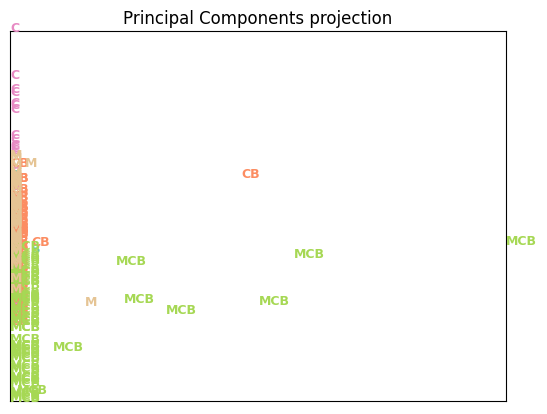

In [13]:
#----------------------------------------------------------------------
# Projection on to the first 2 principal components
def get_most_important_features(X, svd, n=5):
    components = pd.DataFrame(svd.components_, columns=X.columns)
    components_abs = components.abs()
    return components_abs.sum(axis=0).sort_values(ascending=False)[:n].index.tolist()


print("Computing PCA projection")
components = 2

svd = decomposition.TruncatedSVD(n_components=components)
print(X_scaled.shape)
X_pca = svd.fit_transform(X_scaled)
print(X_pca.shape)
print(svd.components_)
print("Most important features")
mif = get_most_important_features(pd.DataFrame(X_scaled), svd, n=5)
print(mif)
# use mif indices to get column names in dfSelected
# print(X_scaled.columns[mif])

# plot the PCA projection
plot_embedding(X_pca,
                "Principal Components projection", components)

# export the PCA projection to a csv file
columns = []
for i in range(components):
    columns.append('PC{}'.format(i+1))
dfPCA = pd.DataFrame(X_pca, columns=columns)
# dfPCA = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
# for each value in the "Group" column in y, save the number of the group (which is the indext of the group list)
dfPCA['Group'] = [groups.index(i) for i in y]
dfPCA.to_csv('PCA_{}.csv'.format(datetime.datetime.now().strftime('%Y-%m-%d')), index=False)

## LDA

Main fields distinguishing classes

  Class 1:
    1. Relative 3D Surface Area - 10.16
    2. Filled Area - 10.05
    3. Structure Count - 1.16
    4. Number of Isolates - 0.68
    5. Average Edge Length - 0.56
    6. Fusion Events - 0.51
    7. Aspect Ratio 3D Main/Middle - 0.48
    8. Aspect Ratio 3D Main/Minor - 0.26
    9. 3D Volume (µm^3) - 0.20
    10. Depolarization Events - 0.14
    11. Relative 3D Solidity - 0.12
    12. Fission/Fusion Ratio - 0.11
    13. Extent - 0.11
    14. Fission Events - 0.11
    15. Relative 3D Convex Volume - 0.11
    16. Total Number of Edges - 0.06
    17. Number of Self-loops - 0.04
    18. Relative 3D Convexity - 0.03
    19. Sphericity - 0.01
    20. Aspect Ratio Major/Minor - 0.00
                  feature_names  feature_importances
13     Relative 3D Surface Area            10.157473
9                   Filled Area            10.046272
3               Structure Count             1.155525
4            Number of Isolates             0.681287
6   

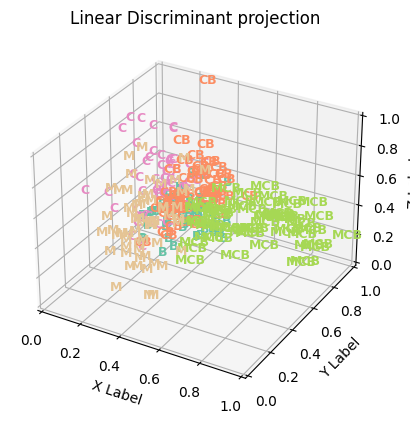

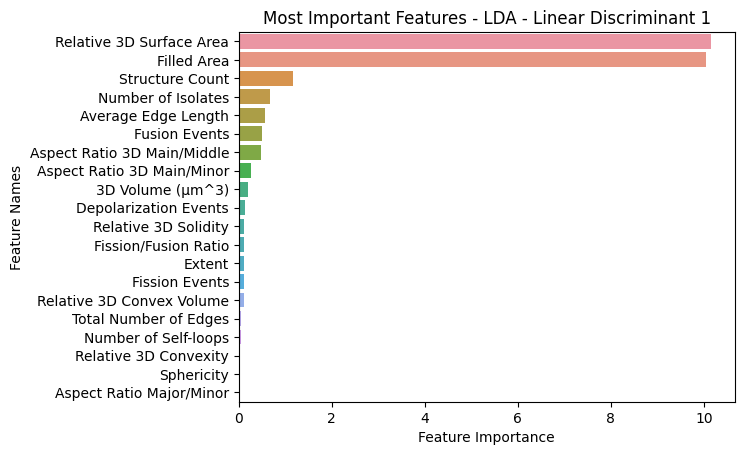

                  feature_names  feature_importances
3               Structure Count             2.231893
13     Relative 3D Surface Area             1.520394
0                 Fusion Events             1.331840
9                   Filled Area             1.226340
7         Total Number of Edges             0.729552
11  Aspect Ratio 3D Main/Middle             0.553685
15    Relative 3D Convex Volume             0.546088
12   Aspect Ratio 3D Main/Minor             0.530473
19         Fission/Fusion Ratio             0.366089
16        Relative 3D Convexity             0.364658


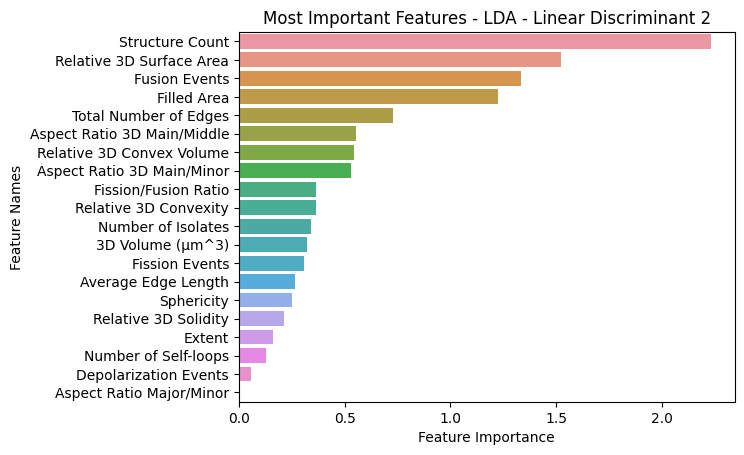

                  feature_names  feature_importances
9                   Filled Area             4.899682
14             3D Volume (µm^3)             2.529297
16        Relative 3D Convexity             1.886884
15    Relative 3D Convex Volume             1.546019
18                   Sphericity             1.496344
7         Total Number of Edges             1.364450
13     Relative 3D Surface Area             1.100642
6           Average Edge Length             1.053537
3               Structure Count             0.859277
11  Aspect Ratio 3D Main/Middle             0.486982


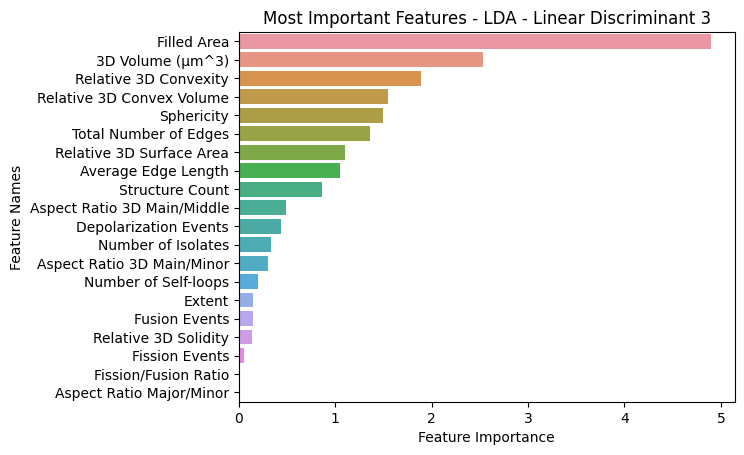

                feature_names  feature_importances
13   Relative 3D Surface Area             7.935236
9                 Filled Area             5.554355
14           3D Volume (µm^3)             2.697033
18                 Sphericity             0.896311
0               Fusion Events             0.652531
5        Number of Self-loops             0.552658
6         Average Edge Length             0.533256
4          Number of Isolates             0.498397
7       Total Number of Edges             0.356262
15  Relative 3D Convex Volume             0.324030


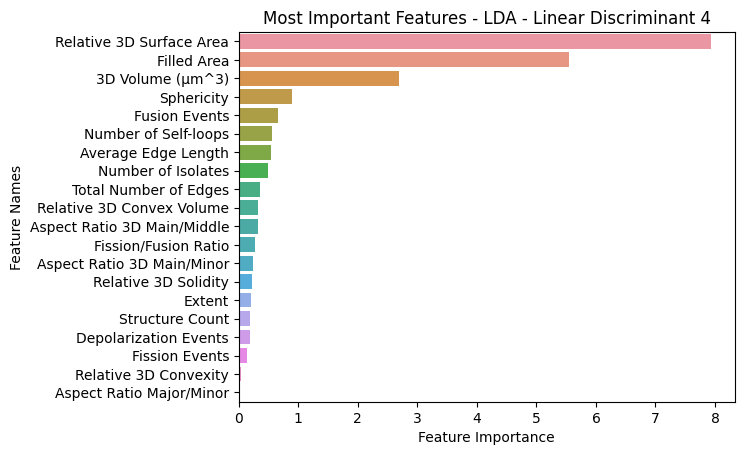

                feature_names  feature_importances
9                 Filled Area            21.726649
13   Relative 3D Surface Area            20.713746
14           3D Volume (µm^3)             5.752139
3             Structure Count             4.431045
18                 Sphericity             2.653877
0               Fusion Events             2.639233
15  Relative 3D Convex Volume             2.522346
7       Total Number of Edges             2.506465
6         Average Edge Length             2.414725
16      Relative 3D Convexity             2.321034


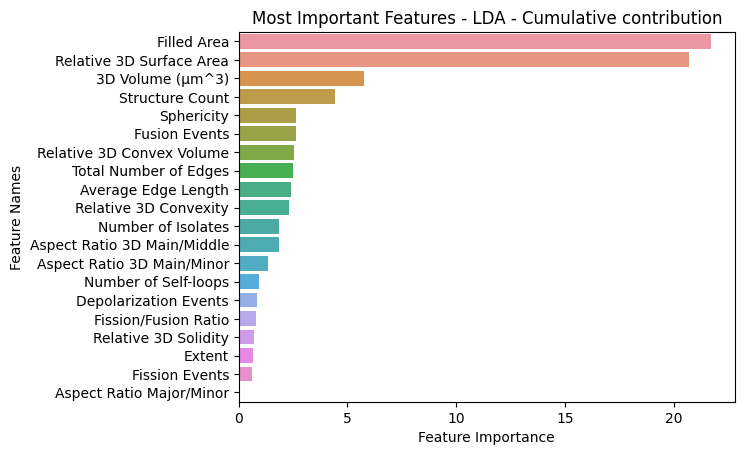

In [14]:

X2 = X.copy()
X2.flat[::X.shape[1] + 1] += 0.01  # Make X invertible

components = min(3, len(np.unique(y)) - 1)

LDA_obj = LDA(n_components=components)
X_lda = LDA_obj.fit_transform(X2, y)


fields = list(dfSelected.columns)
print("Main fields distinguishing classes")
scalings = np.abs(LDA_obj.scalings_)
print("\n  Class 1:")
for i, fieldIndex in enumerate(np.flip(np.argsort(scalings[:,0])), start=1):
    print("    {}. {} - {:.2f}".format(i, fields[fieldIndex], scalings[fieldIndex, 0]))

plot_embedding(X_lda,
               "Linear Discriminant projection", numAxes=components)



for i in range(len(groups) - 1):
    # Create a dataframe with the feature names and their corresponding importances
    feature_importances_df = pd.DataFrame({'feature_names': fields, 'feature_importances': scalings[:,i]})

    # Sort the dataframe by feature importances in descending order
    feature_importances_df.sort_values('feature_importances', inplace=True, ascending=False)

    # Print the top 10 most important features
    print(feature_importances_df.head(10))

    # Plot the top 10 most important features as a horizontal bar chart
    # sns.barplot(data=feature_importances_df.head(10), x='feature_importances', y='feature_names', orient='h')
    # plt.figure(figsize=(10, 6))
    # plt.barh(feature_importances_df['feature_names'], feature_importances_df['feature_importances'])
    # plt.xlabel('Feature Importance')
    # plt.ylabel('Feature Names')
    # plt.title('Top 10 Most Important Features - LDA - Linear Discriminant {}'.format(i + 1))
    # plt.show()

    fig = plt.figure()
    sns.barplot(data=feature_importances_df, x='feature_importances', y='feature_names')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    plt.title('Most Important Features - LDA - Linear Discriminant {}'.format(i + 1))
    plt.show()



# Create a dataframe with the feature names and their corresponding importances
feature_importances_df = pd.DataFrame({'feature_names': fields, 'feature_importances': np.sum(np.abs(scalings), axis=1)})

# Sort the dataframe by feature importances in descending order
feature_importances_df.sort_values('feature_importances', inplace=True, ascending=False)

# Print the top 10 most important features
print(feature_importances_df.head(10))

# Plot the top 10 most important features as a horizontal bar chart
# sns.barplot(data=feature_importances_df.head(10), x='feature_importances', y='feature_names', orient='h')
# plt.figure(figsize=(10, 6))
# plt.barh(feature_importances_df['feature_names'], feature_importances_df['feature_importances'])
# plt.xlabel('Feature Importance')
# plt.ylabel('Feature Names')
# plt.title('Most Important Features - LDA - Cumulative contribution')
# plt.show()


fig = plt.figure()
sns.barplot(data=feature_importances_df, x='feature_importances', y='feature_names')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.title('Most Important Features - LDA - Cumulative contribution')
plt.show()

# # Perform LDA on the dataset
# lda = LDA(n_components=1)
# X_lda = lda.fit_transform(X, y)

# # Create a dataframe with the LDA components
# lda_df = pd.DataFrame(data=X_lda, columns=['LDA_Component_1'])

# # Concatenate the LDA components with the concentration column
# lda_df = pd.concat([lda_df, df['concentration']], axis=1)

# # Print the first 5 rows of the dataframe
# print(lda_df.head())

# # Plot the LDA components
# sns.scatterplot(data=lda_df, x='LDA_Component_1', y='concentration')
# plt.show()



In [15]:
# # OLD ARCHIVE

# #----------------------------------------------------------------------
# # Plot images
# '''
# n_img_per_row = 20
# img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
# for i in range(n_img_per_row):
#     ix = 10 * i + 1
#     for j in range(n_img_per_row):
#         iy = 10 * j + 1
#         img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

# plt.imshow(img, cmap=plt.cm.binary)
# plt.xticks([])
# plt.yticks([])
# plt.title('A selection from the 64-dimensional digits dataset')
# '''


# #----------------------------------------------------------------------
# # Random 2D projection using a random unitary matrix
# print("Computing random projection")
# rp = random_projection.SparseRandomProjection(n_components=2, random_state=42)
# X_projected = rp.fit_transform(X)
# plot_embedding(X_projected, "Random Projection")


# #----------------------------------------------------------------------
# # Projection on to the first 2 principal components

# print("Computing PCA projection")
# t0 = time()
# X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
# plot_embedding(X_pca,
#                "Principal Components projection (time %.2fs)" %
#                (time() - t0))

# #----------------------------------------------------------------------
# # Projection on to the first 2 linear discriminant components

# print("Computing Linear Discriminant Analysis projection")
# X2 = X.copy()
# X2.flat[::X.shape[1] + 1] += 0.01  # Make X invertible
# t0 = time()
# LDA_obj = discriminant_analysis.LinearDiscriminantAnalysis(n_components=2)
# X_lda = LDA_obj.fit_transform(X2, y)


# fields = list(dfSelected.columns)
# print("Main fields distinguishing classes")
# scalings = np.abs(LDA_obj.scalings_)
# print("\n  Class 1:")
# for i, fieldIndex in enumerate(np.flip(np.argsort(scalings[:,0])), start=1):
#     print("    {}. {} - {:.2f}".format(i, fields[fieldIndex], scalings[fieldIndex, 0]))

# print("\n  Class 2:")
# for i, fieldIndex in enumerate(np.flip(np.argsort(scalings[:,1])), start=1):
#     print("    {}. {} - {:.2f}".format(i, fields[fieldIndex], scalings[fieldIndex, 1]))

# print("\n  Class 3")
# for i, fieldIndex in enumerate(np.flip(np.argsort(scalings[:,2])), start=1):
#     print("    {}. {} - {:.2f}".format(i, fields[fieldIndex], scalings[fieldIndex, 2]))

# print("\n  Class 4:")
# for i, fieldIndex in enumerate(np.flip(np.argsort(scalings[:,3])), start=1):
#     print("    {}. {} - {:.2f}".format(i, fields[fieldIndex], scalings[fieldIndex, 3]))


# plot_embedding(X_lda,
#                "Linear Discriminant projection (time %.2fs)" %
#                (time() - t0))



# #----------------------------------------------------------------------
# # t-SNE embedding dataset
# print("Computing t-SNE embedding")
# tsne = manifold.TSNE(n_components=2, perplexity=10, init='random', random_state=0, verbose=1, learning_rate=200, n_iter=10000)
# t0 = time()
# X_tsne = tsne.fit_transform(X)

# plot_embedding(X_tsne,
#                "t-SNE embedding (time %.2fs)" %
#                (time() - t0))





# # plt.show()

In [16]:
# https://umap-learn.readthedocs.io/en/latest/basic_usage.html#
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

reducer = umap.UMAP()

# umapScaledData = StandardScaler().fit_transform(dfSelected)
# https://www.kaggle.com/code/bextuychiev/beautiful-umap-tutorial-on-100-dimensional-data
pipe = make_pipeline(SimpleImputer(strategy="mean"), QuantileTransformer())   #PowerTransformer QuantileTransformer
umapScaledData = pipe.fit_transform(dfSelected)

embedding = reducer.fit_transform(umapScaledData)
embedding.shape

/opt/homebrew/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/lib/python3.11/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keywo

(300, 2)

/opt/homebrew/lib/python3.11/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/lib/python3.11/site-packages/umap/plot.py:885: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  warn(


Connectivity plot not available


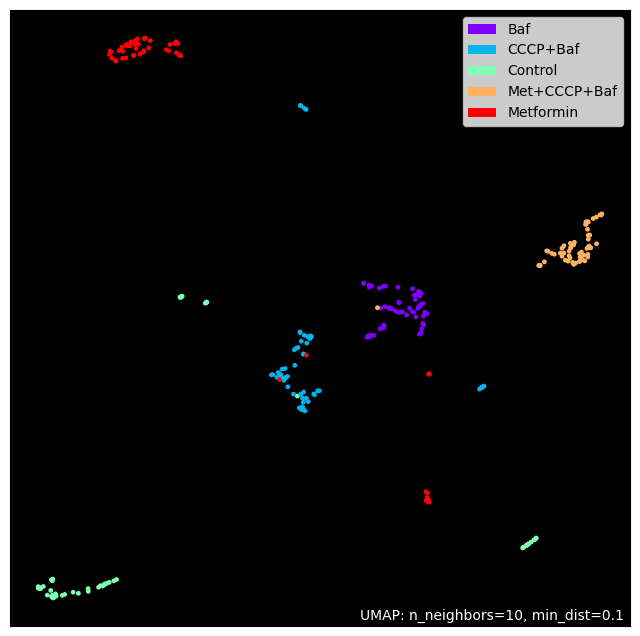

In [17]:
import umap.plot as uplot # pip install umap-learn[plot]
import umap.umap_ as umap

# Encode the target to numeric
y_encoded = pd.factorize(y)[0]
manifold = umap.UMAP(n_neighbors=10).fit(umapScaledData, y_encoded)
uplot.points(manifold, labels=y, theme="fire")
try:
    uplot.connectivity(manifold, labels=y, theme="fire", edge_bundling='hammer')
except:
    print("Connectivity plot not available")

In [18]:
# Train a classifier on th dfSelected dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

def plotConfusionMatrix(x_labels, y_test, y_pred):
    # show confusion matrix
    # use class name as labels
    class_names = np.array(x_labels)
    cm = confusion_matrix(y_test, y_pred)
    # plot confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title("Confusion Matrix for classification")
    plt.show()

Accuracy: 0.63


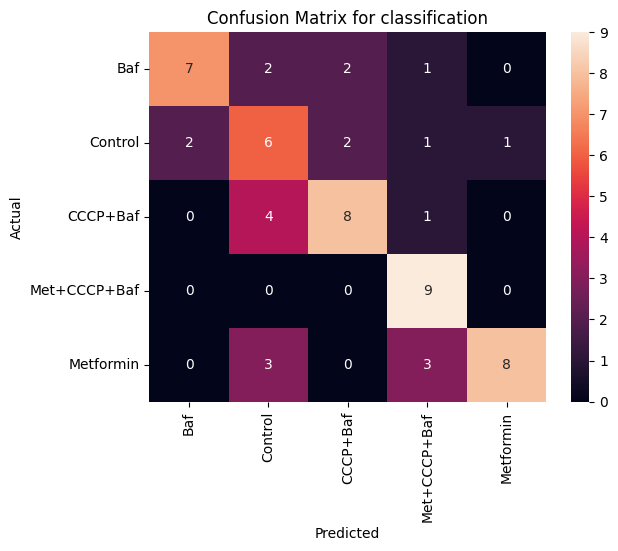

In [19]:
# use UMAP as a classifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(umapScaledData, y, test_size=0.2)

clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))

# lightings = {1: 'White LED', 2: 'Sunlight', 3: 'Fluorescent'}

# plotConfusionMatrix(lightings, y_test, y_pred)
plotConfusionMatrix(groups, y_test, y_pred)


## Random Forrest

Accuracy on test set: 0.700
                 feature_names  feature_importances
3              Structure Count             0.203649
6          Average Edge Length             0.103515
13    Relative 3D Surface Area             0.080610
0                Fusion Events             0.076427
4           Number of Isolates             0.067365
18                  Sphericity             0.062085
16       Relative 3D Convexity             0.055602
7        Total Number of Edges             0.048743
9                  Filled Area             0.047699
12  Aspect Ratio 3D Main/Minor             0.044527


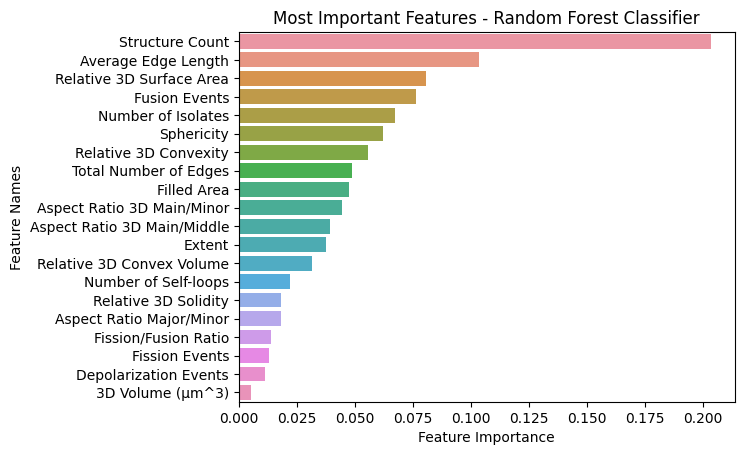

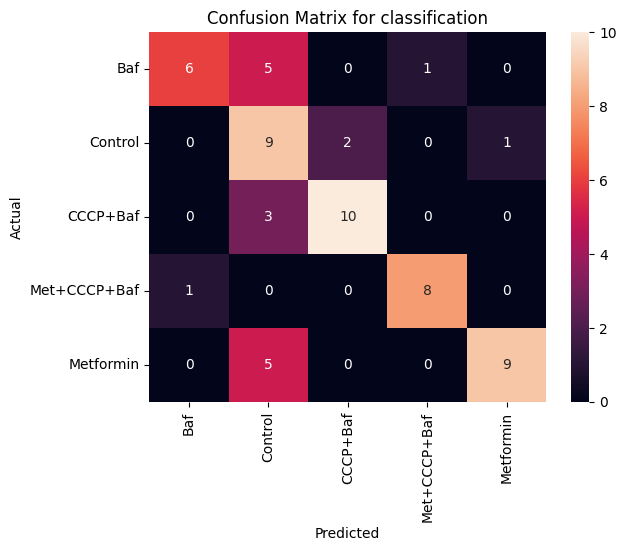

In [20]:

from sklearn.ensemble import RandomForestClassifier

# Train a random forest classifier
rf = RandomForestClassifier(n_estimators=5)
rf.fit(X_train, y_train)

# use rf to get predicted labels for test set
y_pred = rf.predict(X_test)

# Print the accuracy on the test set
print("Accuracy on test set: {:.3f}".format(rf.score(X_test, y_test)))

# Get the feature importances from the trained random forest classifier
importances = rf.feature_importances_

# Create a dataframe with the feature names and their corresponding importances
feature_importances_df = pd.DataFrame({'feature_names': dfSelected.columns, 'feature_importances': importances})

# Sort the dataframe by feature importances in descending order
feature_importances_df.sort_values('feature_importances', inplace=True, ascending=False)

# Print the top 10 most important features
print(feature_importances_df.head(10))

# Plot the top 10 most important features as a horizontal bar chart
# sns.barplot(data=feature_importances_df.head(10), x='feature_importances', y='feature_names')
sns.barplot(data=feature_importances_df, x='feature_importances', y='feature_names')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.title('Most Important Features - Random Forest Classifier')
plt.show()

plotConfusionMatrix(groups, y_test, y_pred)



Accuracy on test set: 0.667


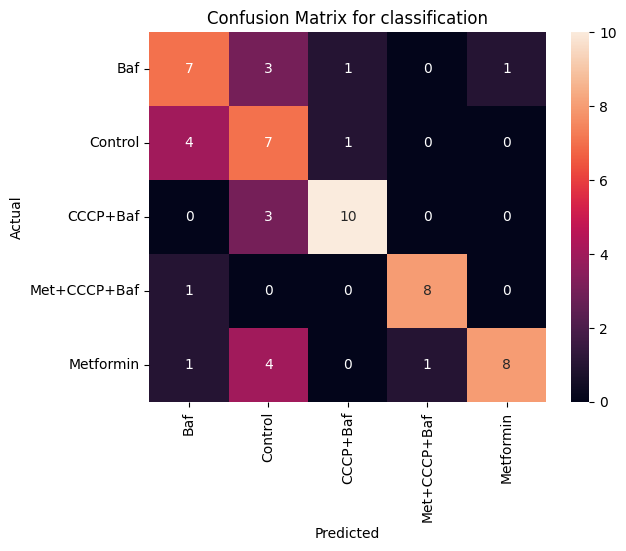

In [21]:
# Train a classifier neural netowrk on th dfSelected dataset
from sklearn.neural_network import MLPClassifier

neurons_per_layer = [200, 100, 100, 50, 25]
mlp = MLPClassifier(hidden_layer_sizes=neurons_per_layer, learning_rate="adaptive", learning_rate_init=0.001, max_iter=100000)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

# Print the accuracy on the test set
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test, y_test)))

plotConfusionMatrix(groups, y_test, y_pred)


In [22]:
# Generate a pair plot using seaborn
# sns.pairplot(dfSelected, hue="Group")